# Import important libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error, mean_absolute_error
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

# ignore warnings   
import warnings
warnings.filterwarnings('ignore')

# Load the dataset

In [2]:
df = pd.read_csv('./data/heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


# Basic data checking

In [3]:
df.shape

(920, 16)

In [4]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [6]:
df.nunique()

id          920
age          50
sex           2
dataset       4
cp            4
trestbps     61
chol        217
fbs           2
restecg       3
thalch      119
exang         2
oldpeak      53
slope         3
ca            4
thal          3
num           5
dtype: int64

## Feature visualization

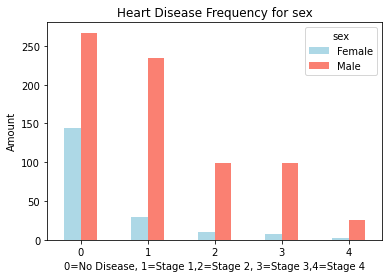

In [9]:
pd.crosstab(df.num,df.sex).plot(kind="bar",figsize=(6,4),color=["lightblue","salmon"])

plt.title("Heart Disease Frequency for sex")

plt.xlabel("0=No Disease, 1=Stage 1,2=Stage 2, 3=Stage 3,4=Stage 4")
plt.ylabel("Amount")

plt.xticks(rotation=0)

plt.show()

### Heart disease frequency per Chest Pain

<Axes: xlabel='cp'>

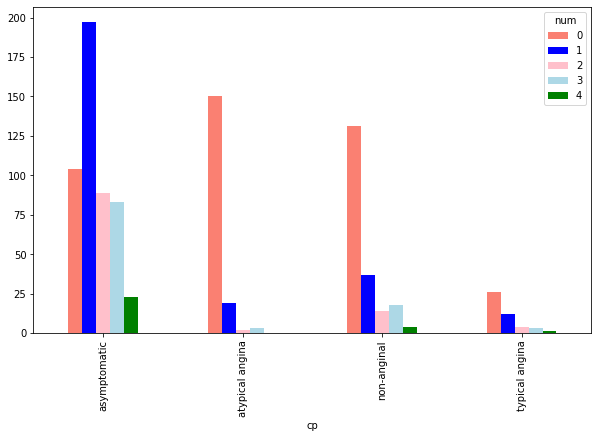

In [11]:
crosstab_num = pd.crosstab(df.cp,df.num)
crosstab_num.plot(
    kind="bar",
    figsize=(10,6), 
    color = ['salmon','blue','pink','lightblue','green']
    )

# Data Preprocessing

## Data Cleaning

### Check for missing values and basic info

In [12]:
basic_info = pd.DataFrame({
    "Features": df.columns,
    "Missing Values": df.isnull().sum(),
    "Missing Values[%]": round((df.isnull().sum())/len(df)*100, 1),
    "Unique Counts": df.nunique(),
    "Data Types": df.dtypes
})
basic_info

,Features,Missing Values,Missing Values[%],Unique Counts,Data Types
id,id,0,0.0,920,int64
age,age,0,0.0,50,int64
sex,sex,0,0.0,2,object
dataset,dataset,0,0.0,4,object
cp,cp,0,0.0,4,object
trestbps,trestbps,59,6.4,61,float64
chol,chol,30,3.3,217,float64
fbs,fbs,90,9.8,2,object
restecg,restecg,2,0.2,3,object
thalch,thalch,55,6.0,119,float64


## Functions for missing value imputation

In [50]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [
        col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)

    iterative_imputer = IterativeImputer(
        estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(
                col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '" + passed_col + "' has been imputed with",
          round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(
                col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]


def impute_continuous_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [
        col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    iterative_imputer = IterativeImputer(
        estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(
                col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(
                col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

In [51]:
# df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False).index.tolist()
missing_data_cols

['ca',
 'thal',
 'slope',
 'fbs',
 'oldpeak',
 'trestbps',
 'thalch',
 'exang',
 'chol',
 'restecg']

In [52]:
categorical_cols = ['thal', 'ca', 'slope', 'exang', 'restecg','fbs', 'cp', 'sex', 'num']
bool_cols = ['fbs', 'exang']
numeric_cols = ['oldpeak', 'thalch', 'chol', 'trestbps', 'age']

In [53]:
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
    else:
        pass

Missing Values ca : 66.41%
The feature 'ca' has been imputed with 61.29 accuracy

Missing Values thal : 52.83%
The feature 'thal' has been imputed with 71.26 accuracy

Missing Values slope : 33.59%
The feature 'slope' has been imputed with 67.48 accuracy

Missing Values fbs : 9.78%
The feature 'fbs' has been imputed with 79.52 accuracy

Missing Values oldpeak : 6.74%
MAE = 0.6139418604651163 

RMSE = 0.8240522392562597 

R2 = 0.353054891576151 

Missing Values trestbps : 6.41%
MAE = 13.418843930635838 

RMSE = 17.43749189818943 

R2 = 0.05060741627033849 

Missing Values thalch : 5.98%
MAE = 16.040173410404623 

RMSE = 20.584960852398957 

R2 = 0.38384581248858884 

Missing Values exang : 5.98%
The feature 'exang' has been imputed with 80.92 accuracy

Missing Values chol : 3.26%
MAE = 45.10112359550562 

RMSE = 63.27817484121959 

R2 = 0.6828048532476962 

Missing Values restecg : 0.22%
The feature 'restecg' has been imputed with 66.85 accuracy



In [54]:
df.isnull().sum()

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

## Checking Correlation with the category

In [57]:
corr = df.corr(numeric_only=True)
corr

,id,age,trestbps,chol,thalch,oldpeak,ca,num
id,1.000000,0.239301,0.067908,-0.366890,-0.461366,0.136528,0.016949,0.273552
age,0.239301,1.000000,0.251652,-0.087446,-0.369405,0.282032,0.415923,0.339596
trestbps,0.067908,0.251652,1.000000,0.096399,-0.110878,0.174388,0.089627,0.131169
chol,-0.366890,-0.087446,0.096399,1.000000,0.222026,0.042806,-0.177043,-0.231979
thalch,-0.461366,-0.369405,-0.110878,0.222026,1.000000,-0.166807,-0.218623,-0.362496
oldpeak,0.136528,0.282032,0.174388,0.042806,-0.166807,1.000000,0.271450,0.461684
ca,0.016949,0.415923,0.089627,-0.177043,-0.218623,0.271450,1.000000,0.553849
num,0.273552,0.339596,0.131169,-0.231979,-0.362496,0.461684,0.553849,1.000000


<Axes: >

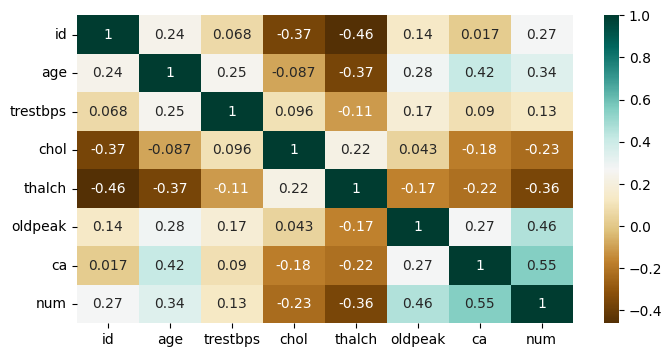

In [60]:
plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap="BrBG")

Text(0.5, 1.0, 'Features Correlating with target (num)')

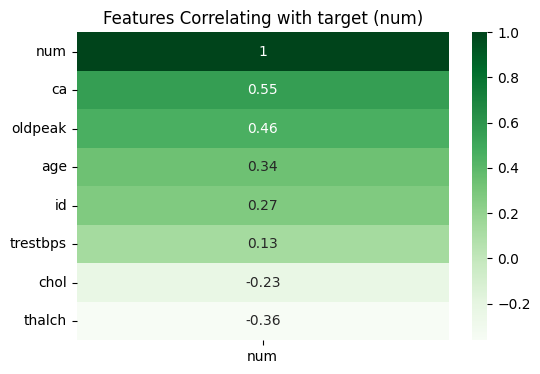

In [66]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(corr[["num"]].sort_values(by="num", ascending=False), annot=True, cmap="Greens")
heatmap.set_title("Features Correlating with target (num)", fontdict={"fontsize":12}, pad=6)

# Machine Learning Algorithms

In [67]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [68]:
df['num'].value_counts()

num
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

## Split the dataset

In [69]:
X = df.drop('num', axis=1)
y = df['num']

In [70]:
X.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal


In [71]:
y.head()

0    0
1    2
2    1
3    0
4    0
Name: num, dtype: int64

In [73]:
# Create a separate label encoder for each categorical column in X
label_encoder =LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype == 'category':
        
        X[col] = label_encoder.fit_transform(X[col])

label_encoder

LabelEncoder()

In [74]:
# separate X data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## ML Models

In [87]:
models = [
    ('Support Vector Machine', SVC(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42))
]

In [90]:
# Iterate over the models and evaluate their performance
for name, model in models:
    # Create a pipeline for each model
    pipeline = Pipeline([
        ('imputer', KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])    
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    
    # Calculate mean accuracy
    mean_accuracy = scores.mean()
    
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Print the performance metrics
    print("Model:", name)
    print("Cross-validation Accuracy:", mean_accuracy)
    print("Test Accuracy:", accuracy)
    print()

Model: Support Vector Machine
Cross-validation Accuracy: 0.6103197674418605
Test Accuracy: 0.6268115942028986

Model: Logistic Regression
Cross-validation Accuracy: 0.6273740310077519
Test Accuracy: 0.605072463768116

Model: Decision Tree
Cross-validation Accuracy: 0.6024588178294573
Test Accuracy: 0.6413043478260869

